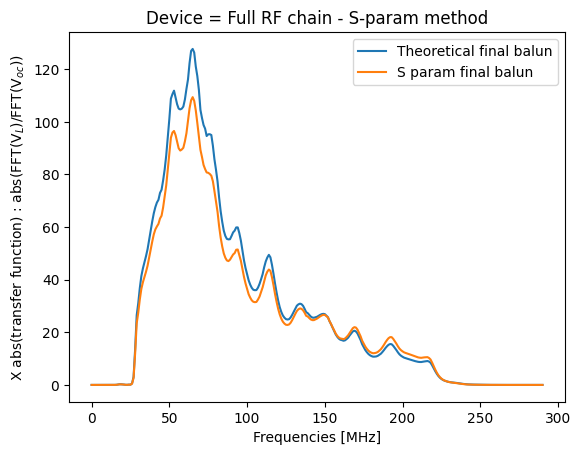

In [21]:
#An example notebook of how to compute the S-matrix and ABCD-matrix of the electronic chain elements,
# how to combine them in order to calculate the total Rf chain and the expected voltage 
# at the output of each element. For more details of how to implement that please see the 
# document https://forge.in2p3.fr/documents/1324.

import numpy as np
import matplotlib.pyplot as plt

#compute VADC from VOC=1


freqs=np.arange(10e6,301e6,1e6) #Hz
axis=1
#plotflag=0
name=[0,'NS','EW','Z']

def interp(x,y,z):
    return np.interp(x,y,z)

def fromABCDtoS(ABCDmatrix,Z0):
    #normalize port 1 and port 2 to Z0
    A=ABCDmatrix[:,0,0]
    B=ABCDmatrix[:,0,1]
    C=ABCDmatrix[:,1,0]
    D=ABCDmatrix[:,1,1]
    a=np.zeros((len(freqs),2,2),dtype='complex')    
    div=A+B/Z0+C*Z0+D
    a[:,0,0]=(A+B/Z0- C*Z0 -D) /div
    a[:,0,1]=2*(A*D-C*B)/div
    a[:,1,0]=2/div
    a[:,1,1]=(-A+B/Z0- C*Z0 +D) /div
    return a

def fromStoABCD(sMatrix,Z01,Z02):
    S11=sMatrix[:,0,0]
    S12=sMatrix[:,0,1]
    S21=sMatrix[:,1,0]
    S22=sMatrix[:,1,1]        
    a=np.zeros((len(freqs),2,2),dtype='complex')
    a[:,0,0]=((1+S11)*(1-S22)+S12*S21) / (2*S21)
    a[:,0,1]=((1+S11)*(1+S22)-S12*S21) / (2*S21)
    a[:,1,0]=((1-S11)*(1-S22)-S12*S21) / (2*S21)
    a[:,1,1]=((1-S11)*(1+S22)+S12*S21) / (2*S21) #beware, typo in a book
    factor=np.array([[1/np.sqrt(Z02/Z01),np.sqrt(Z01*Z02)],[1/np.sqrt(Z01*Z02),1/np.sqrt(Z01/Z02)]]) #to denormalize a
    return a*factor

def fromPolartoAlgebra(sFile,s2p,dB=1):
    lenS=1
    if s2p:
        lenS=4
    sAlgebra=np.zeros((len(freqs),lenS),dtype='complex')
    #print(sFile[0,0],sFile[-1,0])
    for i in range(1,lenS*2+1,2):
        if dB:
            #r=10**(interp(freqs,sFile[:,0],sFile[:,i])/20)
            r=10**(sFile[:,i]/20)
        else:
            #r=interp(freqs,sFile[:,0],sFile[:,i])
            r=sFile[:,i]
        #phi=interp(freqs, sFile[:,0], sFile[:,i+1])
        phi=sFile[:,i+1]*np.pi/180
        #sAlgebra[:,int((i-1)/2)]=r*np.cos(phi*np.pi/180) +1j*r*np.sin(phi*np.pi/180)
        complexnum=r*np.exp(1j*phi)
        sAlgebra[:,int((i-1)/2)]=interp(freqs,sFile[:,0],np.real(complexnum)) +1j*interp(freqs,sFile[:,0],np.imag(complexnum))
        intreshape=int(np.ceil(lenS/2))
    return np.swapaxes(np.reshape(sAlgebra,(len(freqs),intreshape,intreshape)),1,2)

def fromAlgebratoAlgebra(sFile,s2p):
    lenS=1
    if s2p:
        lenS=4
    sAlgebra=np.zeros((len(freqs),lenS),dtype='complex')
    #print(sFile[0,0],sFile[-1,0])
    for i in range(1,lenS*2+1,2):
        re=interp(freqs,sFile[:,0],sFile[:,i])
        im=interp(freqs, sFile[:,0], sFile[:,i+1])
        sAlgebra[:,int((i-1)/2)]=re +1j*im
        intreshape=int(np.ceil(lenS/2))
    return np.swapaxes(np.reshape(sAlgebra,(len(freqs),intreshape,intreshape)),1,2)

def ComputeTFfromABCD(ABCD,ABCDbis,ZL):
    Zin=(ABCD[:,0,0]*ZL+ABCD[:,0,1])/(ABCD[:,1,0]*ZL+ABCD[:,1,1])
    #plt.plot(np.real(Zin))
    #plt.plot(np.imag(Zin))
    #plt.title('Zin')
    #plt.show()
    Voc=1 #V2 scales linearly with Voc
    I1=Voc/(Zin+Zant)
    V1=I1*Zin
    V1I1=np.zeros((len(freqs),2,1),dtype='complex')
    V1I1[:,0,0]=V1
    V1I1[:,1,0]=I1


    invABCD=np.linalg.inv(ABCD)
    invABCDbis=np.linalg.inv(ABCDbis)
    V2=np.matmul(invABCD,V1I1)[:,0,0]
    I2=np.matmul(invABCD,V1I1)[:,1,0]
    V2balun=np.matmul(invABCDbis,V1I1)[:,0,0]
    I2balun=np.matmul(invABCDbis,V1I1)[:,1,0]

    return V2,V2balun,I2
    
    
def ComputeVoltageAtDevice(V2,I2,ABCDdevice): #I2 is relative to the load here (no minus)
    V2I2=np.zeros((len(freqs),2,1),dtype='complex')
    V2I2[:,0,0]=V2
    V2I2[:,1,0]=I2
    Vd=np.matmul(ABCDdevice,V2I2)[:,0,0]
    Id=np.matmul(ABCDdevice,V2I2)[:,1,0]
    
    #plt.plot(freqs/1e6,np.abs(Vd))
    #plt.title(title)
    #plt.xlabel('Frequencies [MHz]')
    #plt.ylabel('X - abs(transfer function) V$_{in}$ : abs(FFT(V)/FFT(V))')
    #plt.show()

    return Vd,Id

def ComputeTFfromABCD(ABCD,ABCDbis,ZL):
    Zin=(ABCD[:,0,0]*ZL+ABCD[:,0,1])/(ABCD[:,1,0]*ZL+ABCD[:,1,1])
    #plt.plot(np.real(Zin))
    #plt.plot(np.imag(Zin))
    #plt.title('Zin')
    #plt.show()
    Voc=1 #V2 scales linearly with Voc
    I1=Voc/(Zin+Zant)
    V1=I1*Zin
    V1I1=np.zeros((len(freqs),2,1),dtype='complex')
    V1I1[:,0,0]=V1
    V1I1[:,1,0]=I1


    invABCD=np.linalg.inv(ABCD)
    invABCDbis=np.linalg.inv(ABCDbis)
    V2=np.matmul(invABCD,V1I1)[:,0,0]
    I2=np.matmul(invABCD,V1I1)[:,1,0]
    V2balun=np.matmul(invABCDbis,V1I1)[:,0,0]
    I2balun=np.matmul(invABCDbis,V1I1)[:,1,0]

    return V2,V2balun,I2
    
    
def ComputeVoltageAtDevice(V2,I2,ABCDdevice): #I2 is relative to the load here (no minus)
    V2I2=np.zeros((len(freqs),2,1),dtype='complex')
    V2I2[:,0,0]=V2
    V2I2[:,1,0]=I2
    Vd=np.matmul(ABCDdevice,V2I2)[:,0,0]
    Id=np.matmul(ABCDdevice,V2I2)[:,1,0]
    
    #plt.plot(freqs/1e6,np.abs(Vd))
    #plt.title(title)
    #plt.xlabel('Frequencies [MHz]')
    #plt.ylabel('X - abs(transfer function) V$_{in}$ : abs(FFT(V)/FFT(V))')
    #plt.show()

    return Vd,Id

#Load s-param files content and plot if flag=1
#sRevBalunF=np.loadtxt('Xidian/v2/balun_reverse.s2p',skiprows=6)
sRevBalunF=np.loadtxt('/home/grand/data/detector/RFchain_v2/balun_in_nut.s2p',skiprows=6)
sMatchingNetF=np.loadtxt('/home/grand/data/detector/RFchain_v2/NewMatchingNetworkX.s2p',skiprows=6)
if axis==3:
    sMatchingNetF=np.loadtxt('/home/grand/data/detector/RFchain_v2/NewMatchingNetworkZ.s2p',skiprows=6)
sLNAF=np.loadtxt('/home/grand/data/detector/RFchain_v2/NewLNA_X.s2p',skiprows=6)
sCableConnectorF=np.loadtxt('/home/grand/data/detector/RFchain_v2/cable+Connector.s2p',skiprows=6)
sVGAFilterF=np.loadtxt('/home/grand/data/detector/RFchain_v2/filter+vga20db+filter.s2p',skiprows=6)
#sBalunLoadF=np.loadtxt('/home/grand/data/detector/RFchain_v2/zload_balun_200ohm.s1p',skiprows=6)
sBalunLoadF=np.loadtxt('/home/grand/data/detector/RFchain_v2/S_balun_AD.s1p',skiprows=6)
sFinalBalunF=np.loadtxt('/home/grand/data/detector/RFchain_v2/balun_before_ad.s2p',skiprows=6)

sRevBalun=fromPolartoAlgebra(sRevBalunF,1,0)
sMatchingNet=fromPolartoAlgebra(sMatchingNetF,1,0)
sLNA=fromPolartoAlgebra(sLNAF,1)
sCableConnector=fromPolartoAlgebra(sCableConnectorF,1)
sVGAFilter=fromPolartoAlgebra(sVGAFilterF,1)
sFinalBalun=fromPolartoAlgebra(sFinalBalunF,1,0)
#sBalunLoad=fromAlgebratoAlgebra(sBalunLoadF,0)
sBalunLoad=fromPolartoAlgebra(sBalunLoadF,0,1)

#ZantF=np.loadtxt('Xidian/v1/ant1.5m/Z_ant_1.5m.csv',skiprows=6,delimiter=',')
ZantF=np.loadtxt('/home/grand/data/detector/RFchain_v2/Z_ant_3.2m.csv',skiprows=6,delimiter=',')
ZantX=interp(freqs,ZantF[:,0]*1e6,ZantF[:,1])+1j*interp(freqs,ZantF[:,0]*1e6,ZantF[:,2])
ZantY=interp(freqs,ZantF[:,0]*1e6,ZantF[:,3])+1j*interp(freqs,ZantF[:,0]*1e6,ZantF[:,4])
ZantZ=interp(freqs,ZantF[:,0]*1e6,ZantF[:,5])+1j*interp(freqs,ZantF[:,0]*1e6,ZantF[:,6])

Zant=ZantX
if axis==2:
    Zant=ZantY
if axis==3:
    Zant=ZantZ
    
Zload=50*(1+sBalunLoad[:,0,0])/(1-sBalunLoad[:,0,0]);  

ABCDfinalBalun=fromStoABCD(sFinalBalun,50,50)    
#since Zload(balun+200ohm)=(Abalun*ZADC+Bbalun)/(Cbalun*ZADC+Dbalun)
ZADC=(Zload*ABCDfinalBalun[:,1,1]-ABCDfinalBalun[:,0,1])/(ABCDfinalBalun[:,0,0]-Zload*ABCDfinalBalun[:,1,0])  

def ComputeTFfromS(sMatrix,ZL,Z01,Z02,title):
    Gant=(Zant-Z01)/(Zant+Z01)
    GL=(ZL-Z02)/(ZL+Z02)
    Gin=sMatrix[:,0,0]+(sMatrix[:,0,1]*sMatrix[:,1,0])/(1-sMatrix[:,1,1]*GL)
    Voc=1
    V2=Voc*0.5*(1-Gant)/(1-Gin*Gant)*sMatrix[:,1,0]*(GL+1)/(1-sMatrix[:,1,1]*GL)
    return V2



ABCDtot=np.matmul(np.matmul(np.matmul(np.matmul(fromStoABCD(sRevBalun,50,50),fromStoABCD(sMatchingNet,50,50)),fromStoABCD(sLNA,50,50)),fromStoABCD(sCableConnector,50,50)),fromStoABCD(sVGAFilter,50,50))
ABCDwbalun=np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(fromStoABCD(sRevBalun,50,50),fromStoABCD(sMatchingNet,50,50)),fromStoABCD(sLNA,50,50)),fromStoABCD(sCableConnector,50,50)),fromStoABCD(sVGAFilter,50,50)),fromStoABCD(sFinalBalun,50,50))


#tests, norm Imp does not matter at the end
sMatrix=fromABCDtoS(ABCDtot,50)
#plotpolar(sMatrix,'TotalRFchain')
sMatrix=fromABCDtoS(ABCDtot,1000)
#plotpolar(sMatrix,'TotalRFchain')
V2th=ComputeTFfromS(sMatrix,Zload,1000,1000,'Device = Full RF chain')
sMatrixwbalun=fromABCDtoS(ABCDwbalun,50)
V2sp=ComputeTFfromS(sMatrixwbalun,ZADC,50,50,'Device = Full RF chain')
plt.plot(np.abs(V2th)*2)
plt.plot(np.abs(V2sp))
title='Device = Full RF chain - S-param method'
plt.title(title)
plt.xlabel('Frequencies [MHz]')
plt.ylabel('X abs(transfer function) : abs(FFT(V$_L$)/FFT(V$_{oc}))$')
plt.legend(['Theoretical final balun','S param final balun'])
plt.show()


#np.savetxt('TF2_20dB_'+name[axis],V2sp)

def ComputeTFfromABCD(ABCD,ABCDbis,ZL):
    Zin=(ABCD[:,0,0]*ZL+ABCD[:,0,1])/(ABCD[:,1,0]*ZL+ABCD[:,1,1])
    #plt.plot(np.real(Zin))
    #plt.plot(np.imag(Zin))
    #plt.title('Zin')
    #plt.show()
    Voc=1 #V2 scales linearly with Voc
    I1=Voc/(Zin+Zant)
    V1=I1*Zin
    V1I1=np.zeros((len(freqs),2,1),dtype='complex')
    V1I1[:,0,0]=V1
    V1I1[:,1,0]=I1


    invABCD=np.linalg.inv(ABCD)
    invABCDbis=np.linalg.inv(ABCDbis)
    V2=np.matmul(invABCD,V1I1)[:,0,0]
    I2=np.matmul(invABCD,V1I1)[:,1,0]
    V2balun=np.matmul(invABCDbis,V1I1)[:,0,0]
    I2balun=np.matmul(invABCDbis,V1I1)[:,1,0]

    return V2,V2balun,I2
    
    
def ComputeVoltageAtDevice(V2,I2,ABCDdevice): #I2 is relative to the load here (no minus)
    V2I2=np.zeros((len(freqs),2,1),dtype='complex')
    V2I2[:,0,0]=V2
    V2I2[:,1,0]=I2
    Vd=np.matmul(ABCDdevice,V2I2)[:,0,0]
    Id=np.matmul(ABCDdevice,V2I2)[:,1,0]
    
    #plt.plot(freqs/1e6,np.abs(Vd))
    #plt.title(title)
    #plt.xlabel('Frequencies [MHz]')
    #plt.ylabel('X - abs(transfer function) V$_{in}$ : abs(FFT(V)/FFT(V))')
    #plt.show()

    return Vd,Id



V2,V2balun,I2=ComputeTFfromABCD(ABCDtot,ABCDwbalun,Zload)
V2,V2balun,I2=ComputeTFfromABCD(ABCDwbalun,ABCDwbalun,ZADC)

VinVGA,I=ComputeVoltageAtDevice(V2,I2,np.matmul(fromStoABCD(sVGAFilter,50,50),fromStoABCD(sFinalBalun,50,50)))
VinCable,I=ComputeVoltageAtDevice(V2,I2,np.matmul(fromStoABCD(sCableConnector,50,50),np.matmul(fromStoABCD(sVGAFilter,50,50),fromStoABCD(sFinalBalun,50,50))))
VinLNA,I=ComputeVoltageAtDevice(V2,I2,np.matmul(fromStoABCD(sLNA,50,50),np.matmul(fromStoABCD(sCableConnector,50,50),np.matmul(fromStoABCD(sVGAFilter,50,50),fromStoABCD(sFinalBalun,50,50)))))

In [8]:
V2sp_X=np.abs(V2sp)

In [9]:
V2sp_Y=np.abs(V2sp)

In [10]:
V2sp_Z=np.abs(V2sp)

In [11]:
#V2sp_Z = np.abs(V2th*2) #V2th

In [12]:
sMatchingNet

array([[[ 0.09305817+0.17522504j,  0.88829485-0.31131859j],
        [ 0.88829485-0.31131859j,  0.1099707 +0.16712671j]],

       [[ 0.10323889+0.18972351j,  0.87431984-0.33893j   ],
        [ 0.87431984-0.33893j   ,  0.123364  +0.17952998j]],

       [[ 0.11407989+0.20345136j,  0.85936671-0.36564422j],
        [ 0.85936671-0.36564422j,  0.13759886+0.19083023j]],

       ...,

       [[ 0.99133442-0.09286524j, -0.01285602+0.01388608j],
        [-0.01285602+0.01388608j,  0.2668969 +0.9261619j ]],

       [[ 0.99107488-0.09630237j, -0.01220953+0.01342264j],
        [-0.01220953+0.01342264j,  0.27778216+0.92410574j]],

       [[ 0.990803  -0.09970824j, -0.01160097+0.01297563j],
        [-0.01160097+0.01297563j,  0.28836215+0.92195588j]]])

In [13]:
sMatchingNet1=np.loadtxt('/home/grand/data/detector/RFchain_v2/NewMatchingNetworkZ.s2p',skiprows=6)

In [14]:
import numpy as np
import scipy.fft as sf
from matplotlib import pyplot as plt
import grand.sim.detector.rf_chain as grfc
import scipy.fft as sf
import h5py

Welcome to JupyROOT 6.26/02


In [15]:
freqs_test=np.arange(10,301,1)
gain=20
rfchain= grfc.RFChain(vga_gain=gain)
tf1=rfchain.compute_for_freqs(freqs_test)
tf_3d =rfchain.get_tf() # the transfer function


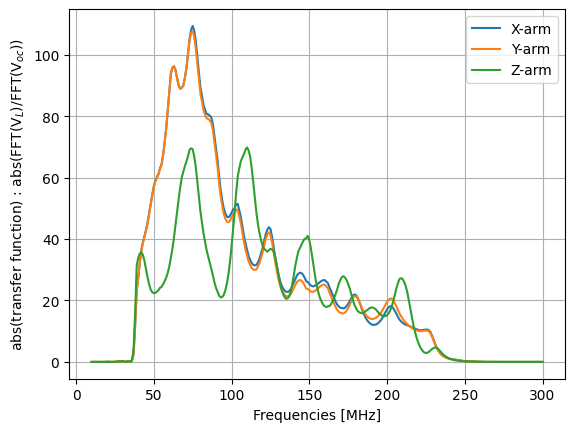

In [16]:
plt.plot(freqs_test,abs(tf_3d[0,:]))
plt.plot(freqs_test,abs(tf_3d[1,:]))
plt.plot(freqs_test,abs(tf_3d[2,:]))
plt.xlabel('Frequencies [MHz]')
plt.ylabel('abs(transfer function) : abs(FFT(V$_{L}$)/FFT(V$_{oc}))$')
plt.legend(['X-arm','Y-arm','Z-arm'])
plt.grid()

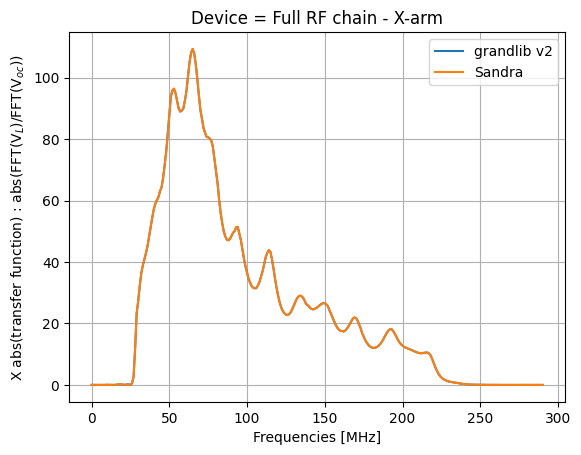

In [17]:
plt.plot(np.abs(tf_3d[0,:]))
plt.plot(np.abs(V2sp_X))
title='Device = Full RF chain - X-arm'
plt.title(title)
plt.xlabel('Frequencies [MHz]')
plt.ylabel('X abs(transfer function) : abs(FFT(V$_L$)/FFT(V$_{oc}))$')
plt.legend(['grandlib v2','Sandra'])
plt.grid()
plt.show()

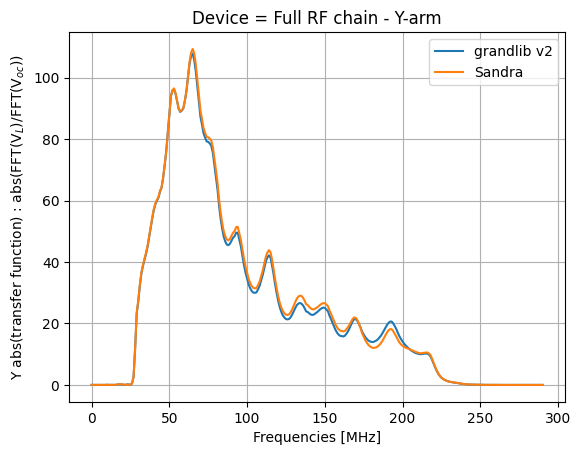

In [18]:
plt.plot(np.abs(tf_3d[1,:]))
plt.plot(np.abs(V2sp_Y))
title='Device = Full RF chain - Y-arm'
plt.title(title)
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Y abs(transfer function) : abs(FFT(V$_L$)/FFT(V$_{oc}))$')
plt.legend(['grandlib v2','Sandra'])
plt.grid()
plt.show()